In [50]:
import easyocr
import cv2
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from image_processing import ImagePreprocessor
import matplotlib.pyplot as plt
from random import sample

In [26]:
# Define paths
license_plate_dir = 'ANPR_IMAGAS1'

# List all files in the train directory
image_files = os.listdir(license_plate_dir)

# Full path to the image file
image_path = os.path.join(license_plate_dir, image_files[53])
image_path

'ANPR_IMAGAS1\\BR 21GB 9036.jpg'

In [30]:
def display_image(image, title="Image"):
    """Display the image using matplotlib."""
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 7), dpi=123)
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

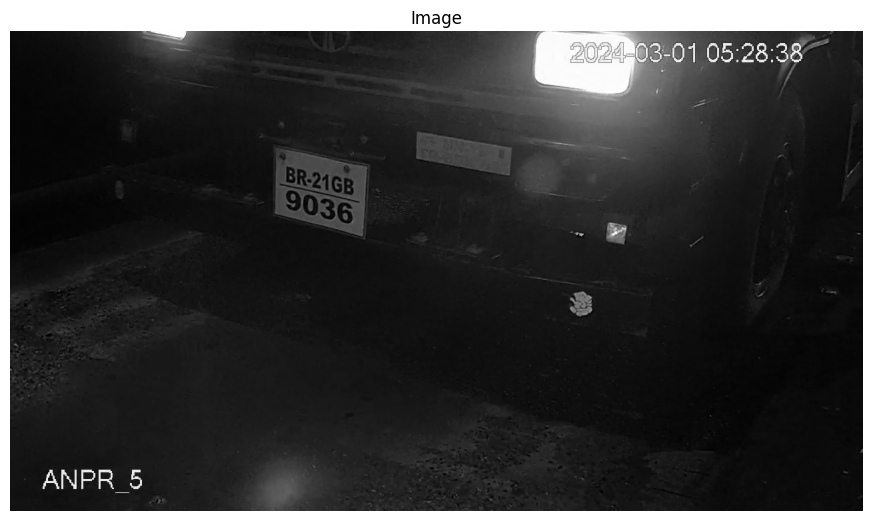

In [41]:
image = cv2.imread(image_path)

height, width, channel = image.shape

display_image(image)

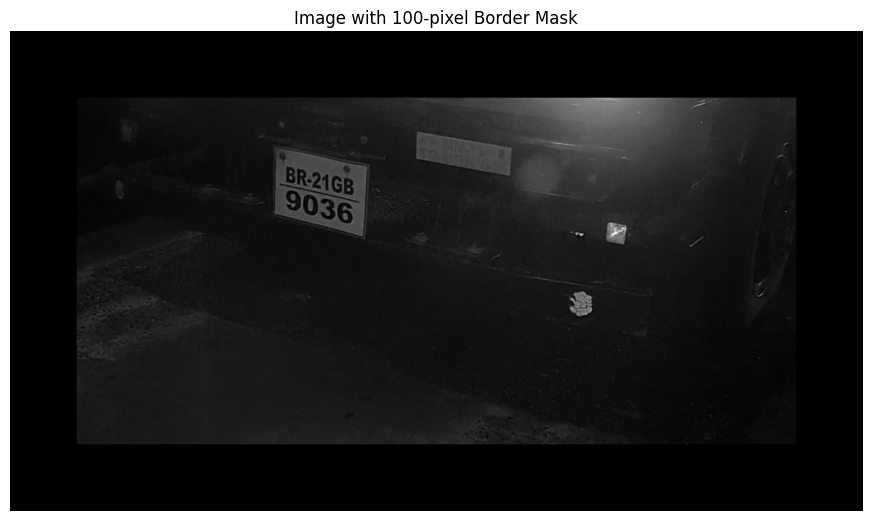

In [36]:
def apply_border_mask(image, border_size=100):
    """
    Applies a border mask to the given image, masking a specified border size on all sides.

    Parameters:
        image (np.ndarray): The original image.
        border_size (int): The size of the border to mask (in pixels). Default is 150.

    Returns:
        np.ndarray: The image with the border masked.
    """
    # Get the image dimensions
    height, width = image.shape[:2]

    # Create an empty mask with the same height and width as the image, but only 1 channel
    mask = np.zeros((height, width), dtype=np.uint8)

    # Fill the central area with ones (255 for an 8-bit mask)
    mask[border_size:height-border_size, border_size:width-border_size] = 255

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    return masked_image




# Apply the border mask
masked_image = apply_border_mask(image)

# Display the masked image
display_image(masked_image, "Image with 100-pixel Border Mask")

In [37]:
# Initialize the EasyOCR Reader
reader = easyocr.Reader(['en'])

# Use EasyOCR to read text from the image
results = reader.readtext(masked_image)
results

[([[411.28445824720006, 193.06452035960038],
   [527.9759441264418, 217.5619722572564],
   [518.7155417527999, 255.93547964039962],
   [402.0240558735582, 231.4380277427436]],
  'BR ZIGB',
  0.4162929505321687),
 ([[411.228115598632, 226.0599398312445],
   [528.9668646606814, 255.4253214442187],
   [515.7718844013681, 299.9400601687555],
   [398.0331353393187, 270.5746785557813]],
  '9036',
  0.9994878768920898)]

Plate Number:BRZIGB9036
Confidence  :0.71


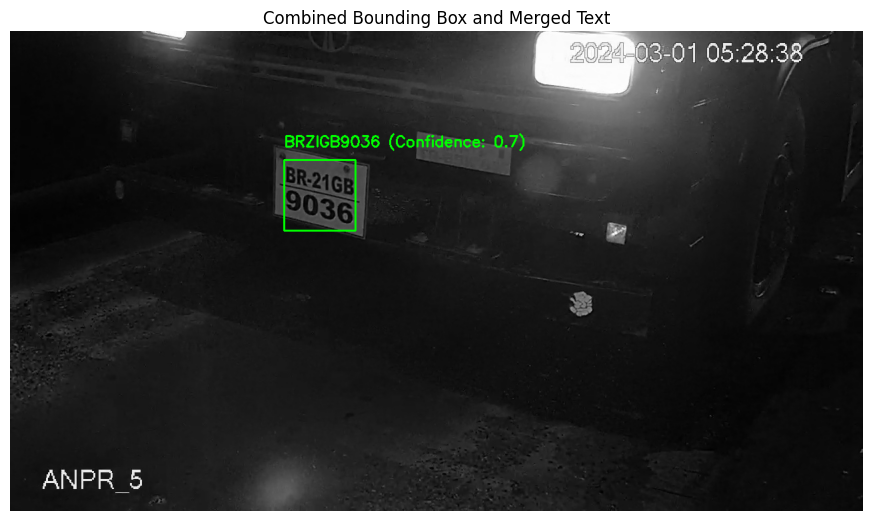

In [46]:
def combine_bounding_boxes_and_text(results, Image):
    """
    Combines all bounding boxes into a single one and merges all detected text.

    Parameters:
        results (list): List of tuples containing (bbox, text, prob) for detected elements.
        image (np.ndarray): The image on which to draw the combined bounding box and text.

    Returns:
        np.ndarray: The image with a combined bounding box and merged text.
    """
    image= Image.copy()
    if not results:
        return image

    # Initialize the combined bounding box coordinates
    min_x, min_y = np.inf, np.inf
    max_x, max_y = -np.inf, -np.inf

    # Initialize the combined text
    combined_text = ""
    combined_prob = 0.0

    for (bbox, text, prob) in results:
        # Update the combined text and average confidence score
        cleaned_text = re.sub(r'[^A-Z0-9]', '', text.strip())
        combined_text +=cleaned_text.upper()
        combined_prob += prob

        # Unpack the bounding box
        (top_left, _, bottom_right, _) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        # Update the bounding box coordinates
        min_x = min(min_x, top_left[0])
        min_y = min(min_y, top_left[1])
        max_x = max(max_x, bottom_right[0])
        max_y = max(max_y, bottom_right[1])

    # Calculate the average confidence score
    combined_prob /= len(results)

    # Draw the combined bounding box
    cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

    # Add the combined text label on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.75
    color = (0, 255, 0)  # Green color for the text
    thickness = 2
    text_position = (min_x, min_y - 20)  # Positioning the text above the bounding box

    cv2.putText(image, f"{combined_text.strip()} (Confidence: {combined_prob:.1f})", 
                text_position, font, font_scale, color, thickness)

    return {'Resulted image':image, 
            'Plate Number':combined_text, 
            'Confidence':combined_prob}


# Apply the function to combine bounding boxes and text
res = combine_bounding_boxes_and_text(results, image)
print(f"Plate Number:{res['Plate Number']}\nConfidence  :{res['Confidence']:.2f}")

# Display the image with the combined bounding box and text using matplotlib
display_image(res['Resulted image'],"Combined Bounding Box and Merged Text")

In [47]:
import easyocr
import cv2
import os
from tqdm import tqdm
import pandas as pd
from image_processing import ImagePreprocessor
import re

# Initialize the EasyOCR Reader
reader = easyocr.Reader(['en'])  # Specify the languages you need

# Define paths
license_plate_dir = 'ANPR_IMAGAS1'
#train_dir = os.path.join(license_plate_dir, 'train')

# Initialize lists to store actual and predicted license plates
actual_plates = []
predicted_plates = []
images_sampled = []
Confidence=[]
# Define valid image extensions
valid_image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

# List all files in the train directory
image_files = os.listdir(license_plate_dir)

# Process each file
for image_file in tqdm(image_files, desc="Processing images"):
    # Get the file extension
    _, ext = os.path.splitext(image_file)
    
    # Skip non-image files
    if ext.lower() not in valid_image_extensions:
        continue
    
    # Extract actual plate from filename
    actual_plate = image_file.split('.')[0].replace('-', '').strip()
    actual_plate = re.sub(r'[^A-Z0-9]', '', actual_plate)
    
    # Full path to the image file
    image_path = os.path.join(license_plate_dir, image_file)
    
    try:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        # Apply the border mask
        masked_image = apply_border_mask(image)
        
        if masked_image is None:
            continue
        
        # Use EasyOCR to read text from the image
        results = reader.readtext(masked_image)
        
        res = combine_bounding_boxes_and_text(results, image)

        # Store actual and predicted plates
        actual_plates.append(actual_plate.strip())
        predicted_plates.append(res['Plate Number'])
        Confidence.append(res['Confidence'])
        images_sampled.append(res['Resulted image'])
    
    except Exception as e:
        print(f"Error processing file {image_file}: {e}")
    break

Processing images:   0%|            | 1/1151 [00:03<58:39,  3.06s/it]


In [48]:
actual_plates[0],predicted_plates[0],Confidence[0]

('0D02AZ8835', '00208835', 0.2892033390921595)

# Save as Dataframe

In [23]:
# Create a DataFrame to save the results
results_df = pd.DataFrame({
    'image':images_sampled,
    'Actual Plate': actual_plates,
    'Predicted Plate': predicted_plates,
    'Confidence Scores':Confidence
})

# Save the results to a CSV file
results_df.to_csv('license_plate_results.csv', index=False)
results_df.head()

,image,Actual Plate,Predicted Plate,Confidence Scores
0,"[[[9, 9, 9], [9, 9, 9], [9, 9, 9], [9, 9, 9], ...",0D0 2AZ 8835.jpg,0D02AZ8835,[0.33019136716575376]
1,"[[[11, 11, 11], [11, 11, 11], [11, 11, 11], [1...",0D0 2CH 7204.jpg,0002CH22041,[0.39638210346525815]
2,"[[[18, 18, 18], [18, 18, 18], [18, 18, 18], [1...",0D22G9662.jpg,ODSPECD2264OKK9662,"[0.6523173124909751, 0.37168438369244333, 0.92..."
3,"[[[101, 99, 100], [104, 100, 101], [108, 102, ...",22 BH 0552D.jpg,2EH0552D,[0.753953022484721]
4,"[[[209, 211, 206], [208, 210, 205], [208, 210,...",22 BH 8408D.jpg,22BH84080,[0.37557566273351306]


# Calculate accuracy

In [24]:
results_df['Predicted Plate']=[''.join(result.split()) for result in results_df['Predicted Plate']]

correct =results_df[results_df['Actual Plate']==results_df['Predicted Plate']]

accuracy= (correct.shape[0]/results_df.shape[0])*100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 0.00%


# Plot some samples

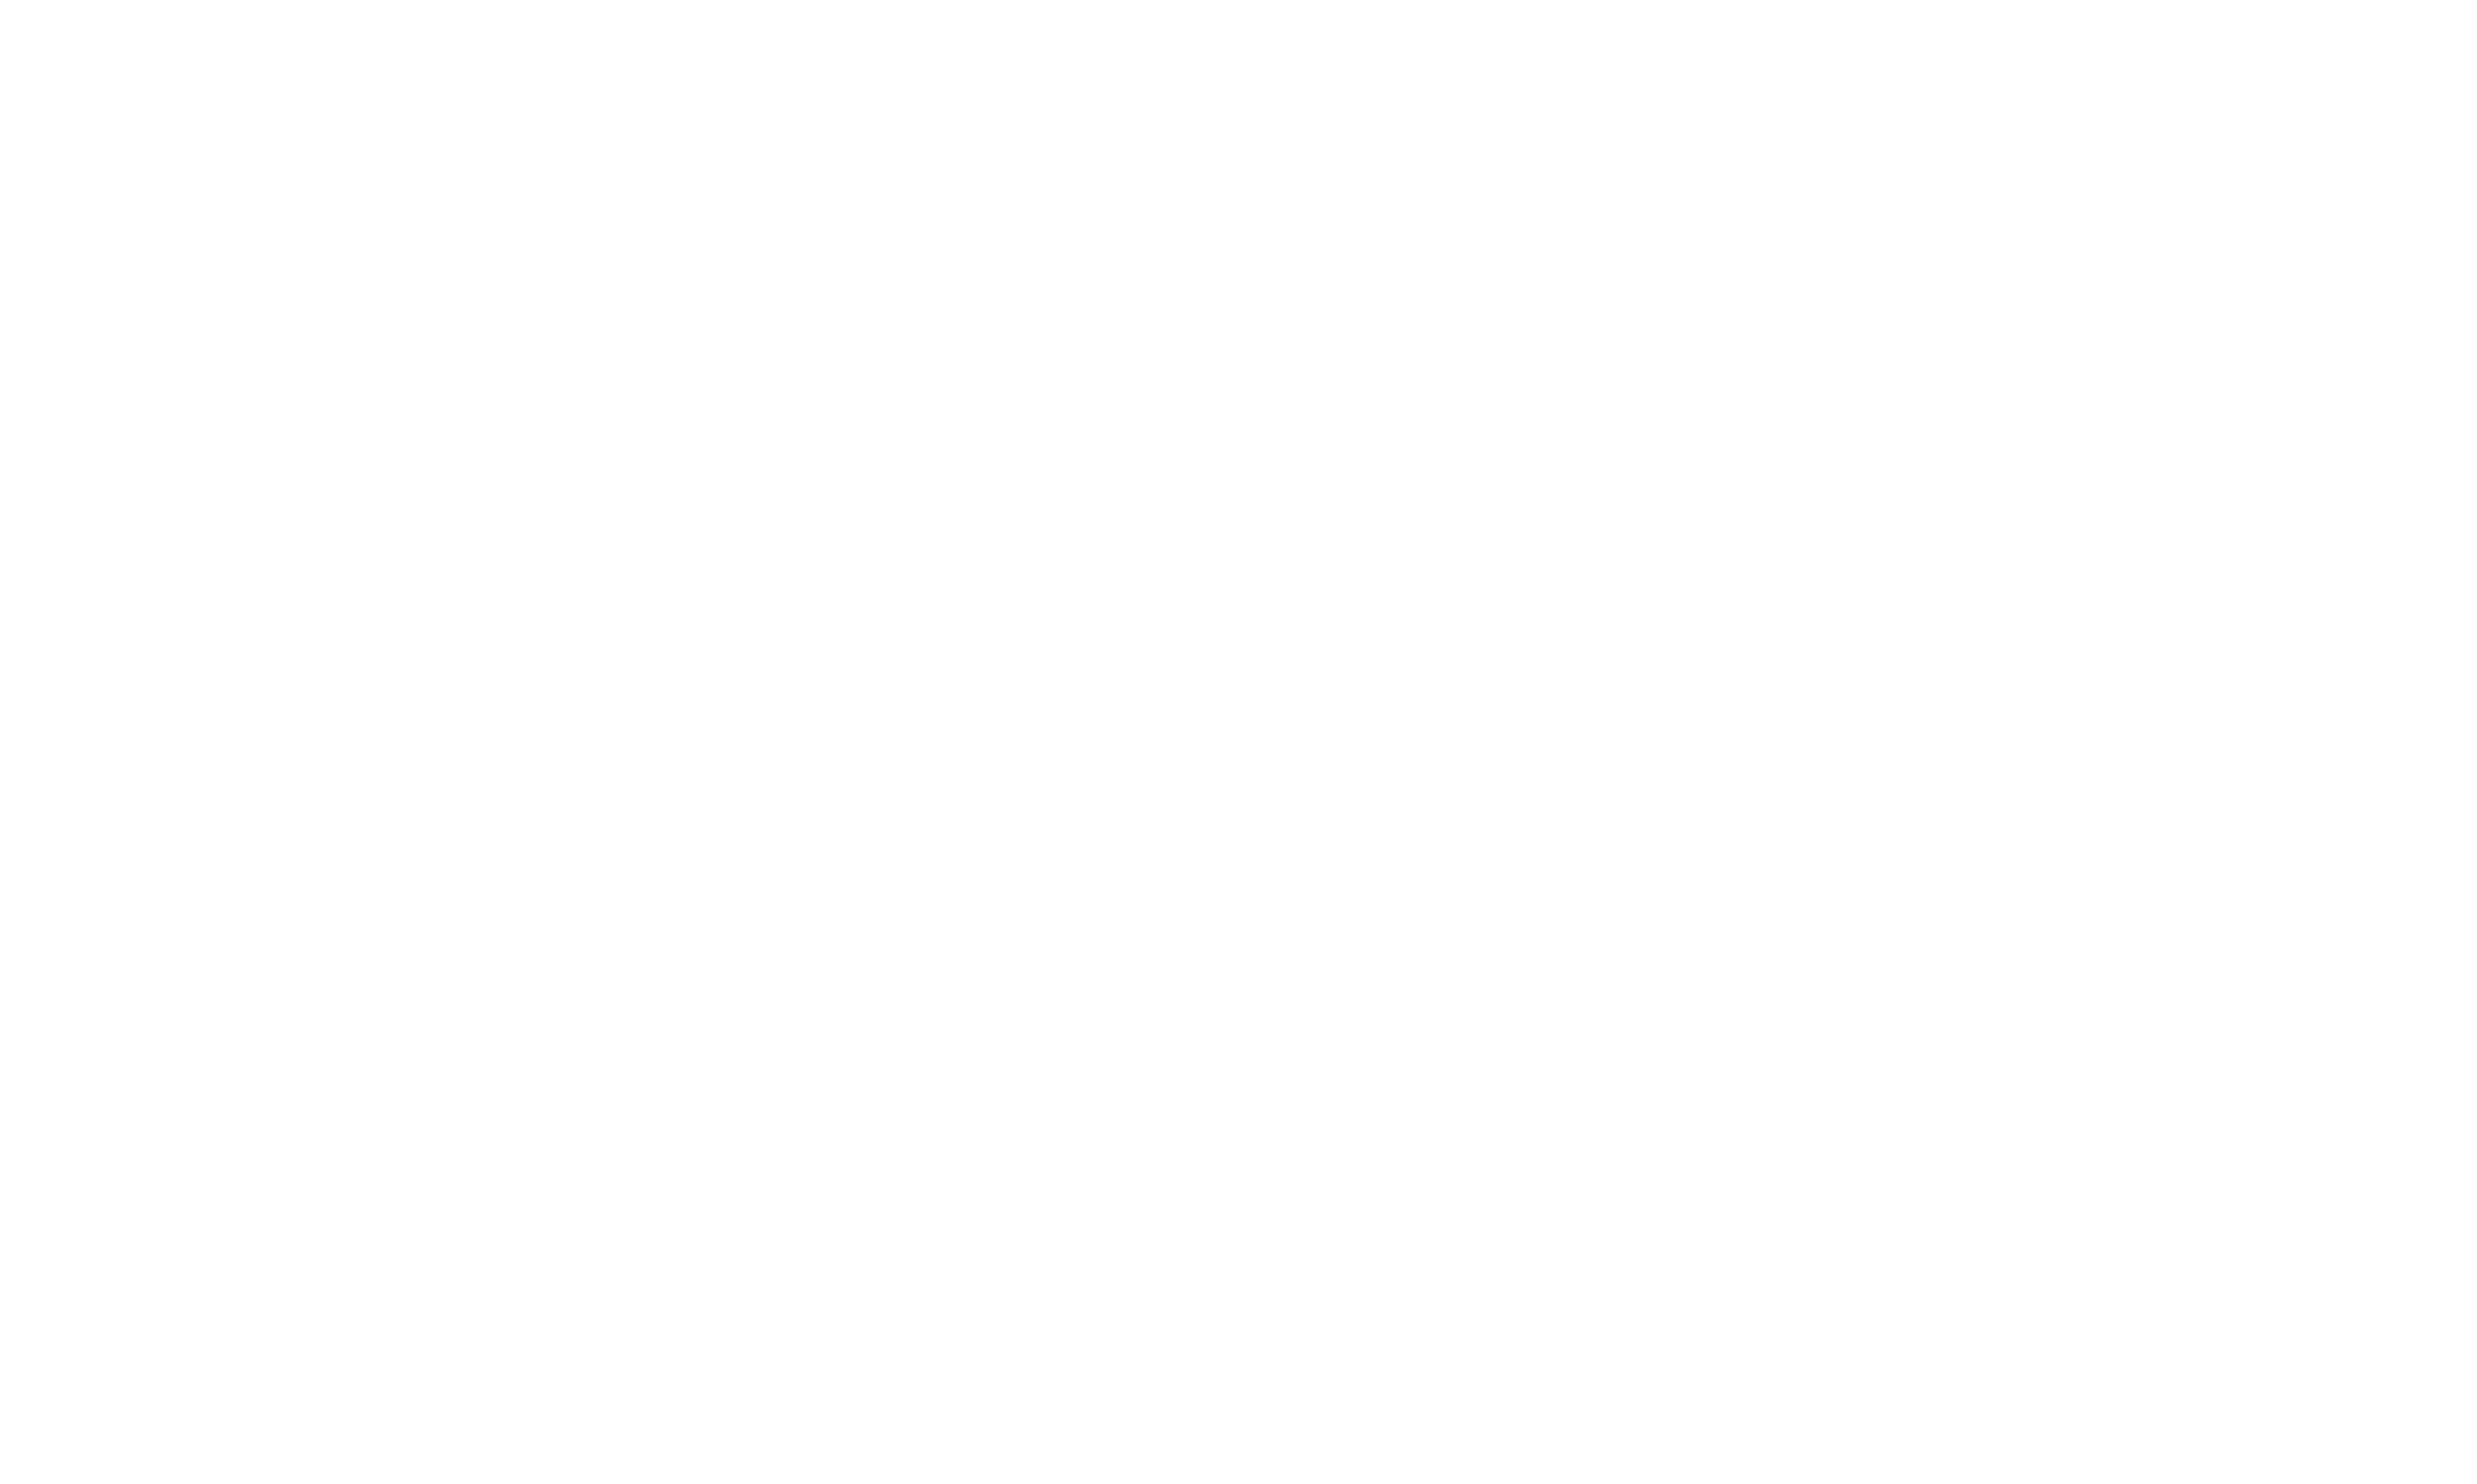

In [51]:
# Filter correct predictions
correct_predictions = results_df[results_df['Actual Plate'] == results_df['Predicted Plate']]

# Prepare data for plotting
correct_samples = list(zip(correct_predictions['image'], 
                           correct_predictions['Actual Plate'], 
                           correct_predictions['Predicted Plate']))

# Sample 50 correct predictions
sampled_correct_samples = sample(correct_samples, min(20, len(correct_samples)))

# Plot the results using matplotlib
fig, axes = plt.subplots(5, 4, figsize=(50,30), dpi=123)  
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(sampled_correct_samples):
        image, actual, predicted = sampled_correct_samples[i]
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Actual: {actual}\nPredicted: {predicted}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="API_KEY")
project = rf.workspace().project("MODEL_ENDPOINT")
model = project.version(VERSION).model

# infer on a local image
print(model.predict("your_image.jpg", confidence=40, overlap=30).json())

# visualize your prediction
# model.predict("your_image.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())